In [15]:
import torch
import torch.nn as nn
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

pix2pix uses a conditional generative adversarial network (cGAN) to learn a mapping from an input image to an output image.

An example of a dataset would be that the input image is a black and white picture and the target image is the color version of the picture. The generator in this case is trying to learn how to colorize a black and white image. The discriminator is looking at the generator’s colorization attempts and trying to learn to tell the difference between the colorizations the generator provides and the true colorized target image provided in the dataset.

The structure of the generator is called an “encoder-decoder” and in pix2pix the encoder-decoder looks more or less like this:

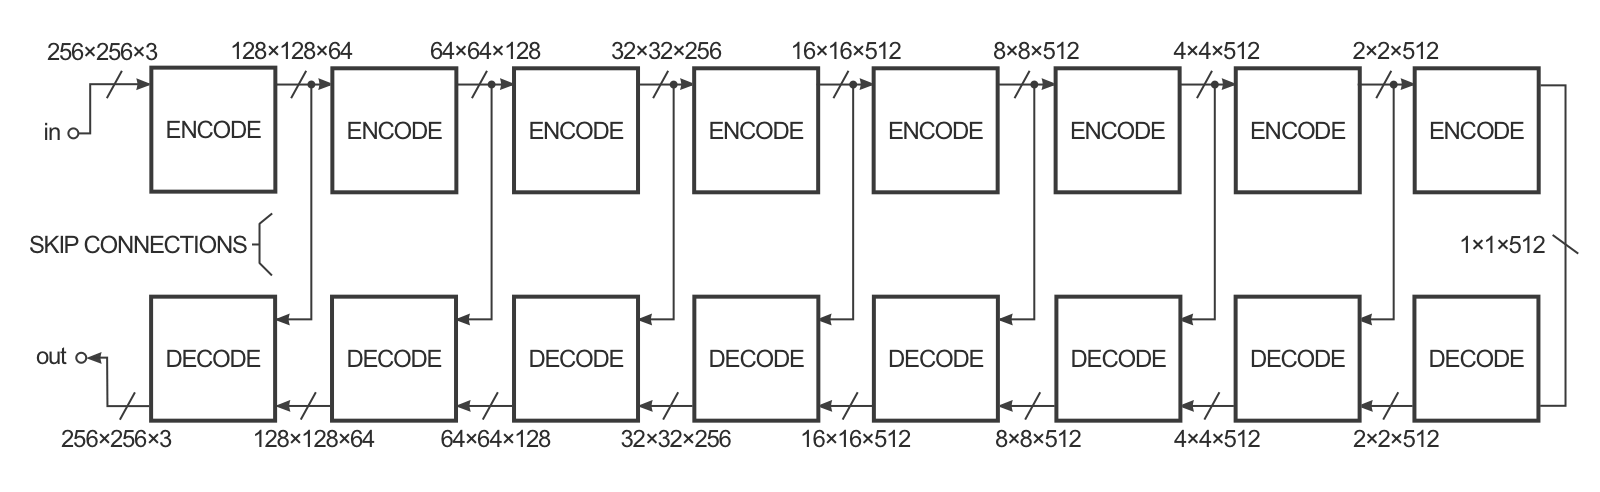

The skip connections give the network the option of bypassing the encoding/decoding part if it doesn’t have a use for it.

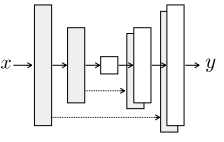

Without z to generator, the net could still learn a mapping from x to y, but would produce deterministic outputs, and there-
fore fail to match any distribution other than a delta function. Past conditional GANs have acknowledged this and
provided Gaussian noise z as an input to the generator, in addition to x. 

In initial experiments, we did not find this strategy effective – the generator simply learned to ignore the noise. Instead, for our final models, we provide noise only in the form of dropout, applied on several layers of our generator at both training and test time. Despite the dropout noise, we observe only minor stochasticity in the output of our nets. Designing conditional GANs that produce highly stochastic output, and thereby capture the full entropy of the conditional distributions they model, is an important question left open by the present work.

In [3]:
class UBlock(nn.Module):
    def __init__(self, s, nf_in, max_nf, use_batchnorm=True, nf_out=None, nf_next=None):
        super(UBlock, self).__init__()
        assert s>=2 and s%2==0
        nf_next = nf_next if nf_next else min(nf_in*2, max_nf)
        nf_out = nf_out if nf_out else nf_in            
        self.conv = nn.Conv2d(nf_in, nf_next, 4, 2, 1, bias=not (use_batchnorm and s>2) )
        if s>2:
            next_block = [nn.BatchNorm2d(nf_next)] if use_batchnorm else []
            next_block += [nn.LeakyReLU(0.2, inplace=True), UBlock(s//2, nf_next, max_nf)]
            self.next_block = nn.Sequential(*next_block)
        else:
            self.next_block = None
        convt = [nn.ReLU(), 
                 nn.ConvTranspose2d(nf_next*2 if self.next_block else nf_next, nf_out,
                                        kernel_size=4, stride=2,padding=1, bias=not use_batchnorm)]    
        if use_batchnorm:
            convt += [nn.BatchNorm2d(nf_out)]        
        if s <= 8:
            convt += [nn.Dropout(0.5, inplace=True)]
        self.convt = nn.Sequential(*convt)  

    def forward(self, x):
        x = self.conv(x)
        if self.next_block:
            x2 = self.next_block(x)
            x = torch.cat((x,x2),1)
        return self.convt(x)        


def UNET_G(isize, nc_in=3, nc_out=3, ngf=64):
    return nn.Sequential(
                  UBlock(isize, nc_in, 8*ngf, False, nf_out=nc_out, nf_next=ngf),
                  nn.Tanh() )

The Discriminator has the job of taking two images, an input image and an unknown image (which will be either a target or output image from the generator), and deciding if the second image was produced by the generator or not.

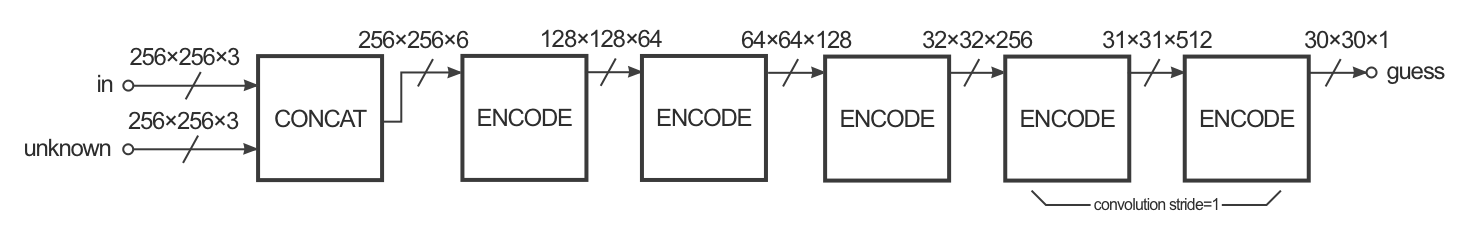

In [4]:
def conv_block(in_feat, out_feat, ksize, stride, padding, 
               activation=nn.LeakyReLU(0.2, inplace=True), use_batchnorm=True):
    layers = [nn.Conv2d(in_feat, out_feat, ksize, stride, padding, bias=not use_batchnorm)]
    if use_batchnorm:
        layers.append(nn.BatchNorm2d(out_feat)) 
    if activation:
        layers.append(activation)
    return nn.Sequential(*layers)

class BASIC_D(nn.Module):
    def __init__(self, nc_in, nc_out, ndf, max_layers=3):
        super(BASIC_D, self).__init__()       
        main = nn.Sequential()
        # input is nc x isize x isize
        main.add_module('initial.{0}-{1}'.format(nc_in+nc_out, ndf),
                        conv_block(nc_in+nc_out, ndf, 4, 2, 1, use_batchnorm=False))
        out_feat = ndf
        for layer in range(1, max_layers):
            in_feat = out_feat
            out_feat = ndf * min(2**layer, 8)
            main.add_module('pyramid.{0}-{1}'.format(in_feat, out_feat),
                                conv_block(in_feat, out_feat, 4, 2, 1, ))           
        in_feat = out_feat
        out_feat = ndf*min(2**max_layers, 8)
        main.add_module('last.{0}-{1}'.format(in_feat, out_feat),
                        conv_block(in_feat, out_feat, 4, 1, 1))
        
        in_feat, out_feat = out_feat, 1        
        main.add_module('output.{0}-{1}'.format(in_feat, out_feat),
                        conv_block(in_feat, out_feat, 4, 1, 1, nn.Sigmoid(), False))
        self.main = main

    def forward(self, a, b):
        x = torch.cat((a, b), 1)        
        output = self.main(x)                    
        return output    

The structure looks a lot like the encoder section of the generator, but works a little differently. The output is a 30x30 image where each pixel value (0 to 1) represents how believable the corresponding section of the unknown image is. In the pix2pix implementation, each pixel from this 30x30 image corresponds to the believability of a 70x70 patch of the input image (the patches overlap a lot since the input images are 256x256). The architecture is called a “PatchGAN”.

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [6]:
nc_in = 3
nc_out = 3
ngf = 64
ndf = 64

#λ = 10

loadSize = 286
imageSize = 256
batchSize = 1
lrD = 2e-4
lrG = 2e-4

In [7]:
netD = BASIC_D(nc_in, nc_out, ndf)
netD.apply(weights_init)

BASIC_D(
  (main): Sequential(
    (initial.6-64): Sequential(
      (0): Conv2d (6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(0.2, inplace)
    )
    (pyramid.64-128): Sequential(
      (0): Conv2d (64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (2): LeakyReLU(0.2, inplace)
    )
    (pyramid.128-256): Sequential(
      (0): Conv2d (128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (2): LeakyReLU(0.2, inplace)
    )
    (last.256-512): Sequential(
      (0): Conv2d (256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
      (2): LeakyReLU(0.2, inplace)
    )
    (output.512-1): Sequential(
      (0): Conv2d (512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (1): S

In [8]:
netG = UNET_G(imageSize, nc_in, nc_out, ngf)
netG.apply(weights_init)

Sequential(
  (0): UBlock(
    (conv): Conv2d (3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (next_block): Sequential(
      (0): LeakyReLU(0.2, inplace)
      (1): UBlock(
        (conv): Conv2d (64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (next_block): Sequential(
          (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
          (1): LeakyReLU(0.2, inplace)
          (2): UBlock(
            (conv): Conv2d (128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
            (next_block): Sequential(
              (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
              (1): LeakyReLU(0.2, inplace)
              (2): UBlock(
                (conv): Conv2d (256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                (next_block): Sequential(
                  (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
                  (1): LeakyReLU(0.2, inp

In [9]:
inputA = torch.FloatTensor(batchSize, nc_in, imageSize, imageSize)
inputB = torch.FloatTensor(batchSize, nc_out, imageSize, imageSize)

In [10]:
netD.cuda()
netG.cuda()
inputA = inputA.cuda()
inputB = inputB.cuda()

In [24]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern)
def read_image(fn, direction=0):
    im = Image.open(fn)
    im = im.resize( (loadSize*2, loadSize), Image.BILINEAR )
    arr = np.array(im)/255*2-1
    w1,w2 = (loadSize-imageSize)//2,(loadSize+imageSize)//2
    h1,h2 = w1,w2
    imgA = arr[h1:h2, loadSize+w1:loadSize+w2, :]
    imgB = arr[h1:h2, w1:w2, :]
    if randint(0,1):
        imgA=imgA[:,::-1]
        imgB=imgB[:,::-1]
    if channel_first:
        imgA = np.moveaxis(imgA, 2, 0)
        imgB = np.moveaxis(imgB, 2, 0)
    if direction==0:
        return imgA, imgB
    else:
        return imgB,imgA

#data = "edges2shoes"
data = "facades"
direction = 0
trainAB = load_data('datasets/{}/train/*.jpg'.format(data))
valAB = load_data('datasets/{}/val/*.jpg'.format(data))
assert len(trainAB) and len(valAB)
len(trainAB)

400

In [12]:
def minibatch(dataAB, batchsize, direction=0):
    length = len(dataAB)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(dataAB)
            i = 0
            epoch+=1        
        dataA = []
        dataB = []
        for j in range(i,i+size):
            imgA,imgB = read_image(dataAB[j], direction)
            dataA.append(imgA)
            dataB.append(imgB)
        dataA = np.float32(dataA)
        dataB = np.float32(dataB)
        i+=size
        tmpsize = yield epoch, dataA, dataB             

In [41]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    #print(int_X)
    display(Image.fromarray(int_X))
    #plt.imshow(np.asarray(Image.fromarray(int_X)))

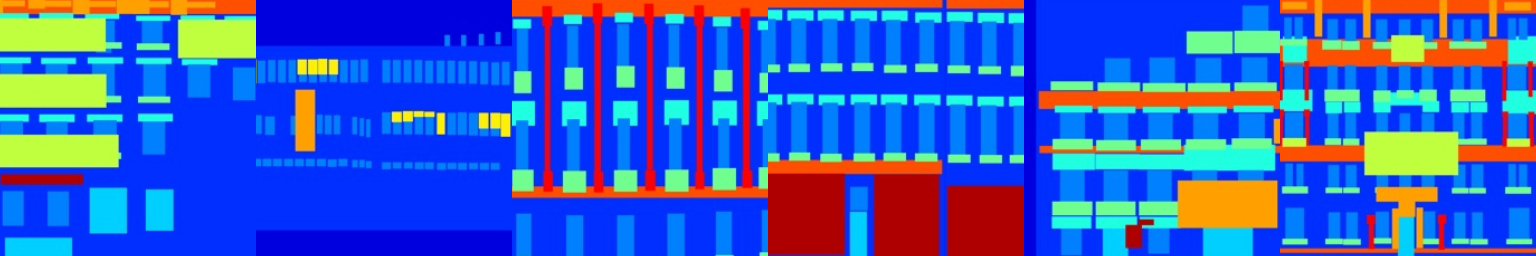

In [42]:
channel_first=True
channel_axis=1
train_batch = minibatch(trainAB, 6, direction=direction)
_, trainA, trainB = next(train_batch)
showX(trainA)
#showX(trainB)
#del train_batch, trainA, trainB

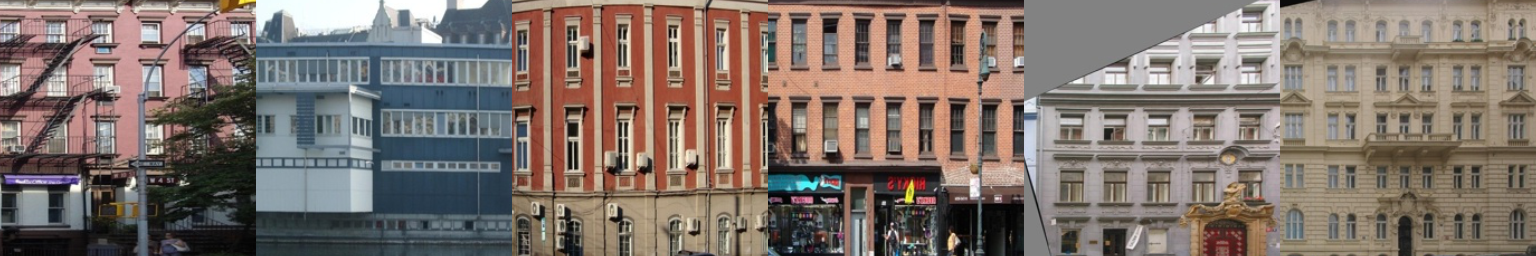

In [43]:
showX(trainB)

In [44]:
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

To train this network, there are two steps: training the discriminator and training the generator.

To train the discriminator, first the generator generates an output image. The discriminator looks at the input/target pair and the input/output pair and produces its guess about how realistic they look. The weights of the discriminator are then adjusted based on the classification error of the input/output pair and the input/target pair.

The generator’s weights are then adjusted based on the output of the discriminator as well as the difference between the output and target image.

In [45]:
optimizerD = optim.Adam(netD.parameters(), lr = lrD, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = lrG, betas=(0.5, 0.999))

In [46]:
loss = nn.BCELoss()
lossL1 = nn.L1Loss()
one = None
zero = None
def netD_train(A, B):    
    global one, zero
    netD.zero_grad()
    output_D_real = netD(A, B)
    if one is None:
        one = Variable(torch.ones(*output_D_real.size()).cuda())
    errD_real = loss(output_D_real, one)
    errD_real.backward()

    output_G = netG(A)
    output_D_fake = netD(A, output_G)
    if zero is None:
        zero = Variable(torch.zeros(*output_D_fake.size()).cuda())
    errD_fake = loss(output_D_fake, zero)
    errD_fake.backward()
    optimizerD.step()
    return (errD_fake.data[0]+errD_real.data[0])/2,


def netG_train(A, B):
    global one
    netG.zero_grad()
    output_G = netG(A)
    output_D_fake = netD(A, output_G)
    if one is None:
        one = Variable(torch.ones(*output_D_fake.size()).cuda())
    errG_fake = loss(output_D_fake, one)    
    errG_L1 = lossL1(output_G, B)
    errG = errG_fake + 100 * errG_L1
    errG.backward()
        
    optimizerG.step()
    return errG_fake.data[0], errG_L1.data[0]


In [47]:
def V(x):
    return Variable(torch.from_numpy(x).cuda())

In [48]:
def netG_gen(A):
    return np.concatenate([netG(A[i:i+1]).data.cpu().numpy() for i in range(A.size()[0])], axis=0)

[145/150][57500] Loss_D: 0.439558 Loss_G: 1.909464 loss_L1: 0.085280 5676.44734406


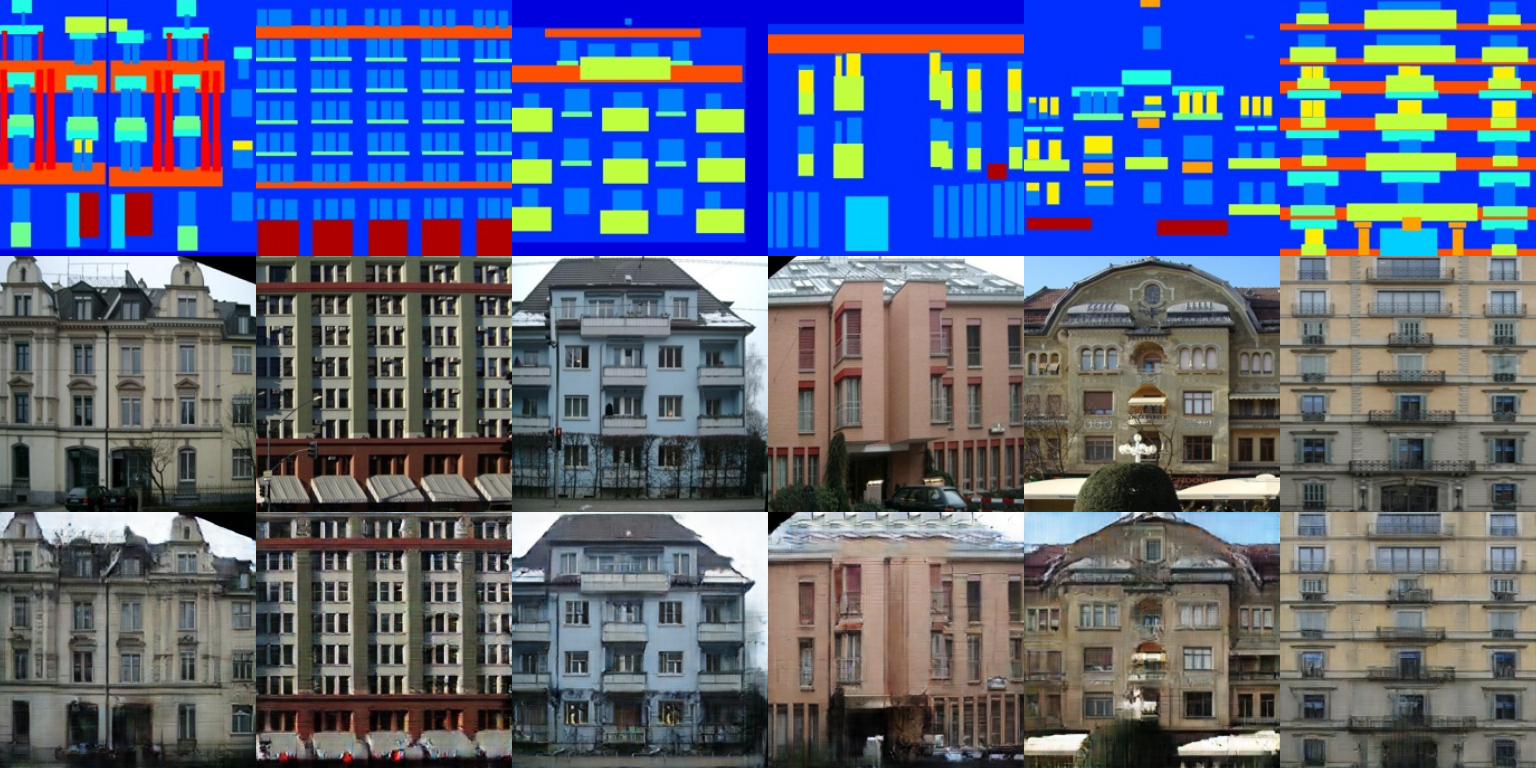

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


[146/150][58000] Loss_D: 0.433600 Loss_G: 1.893871 loss_L1: 0.085766 5725.71646714


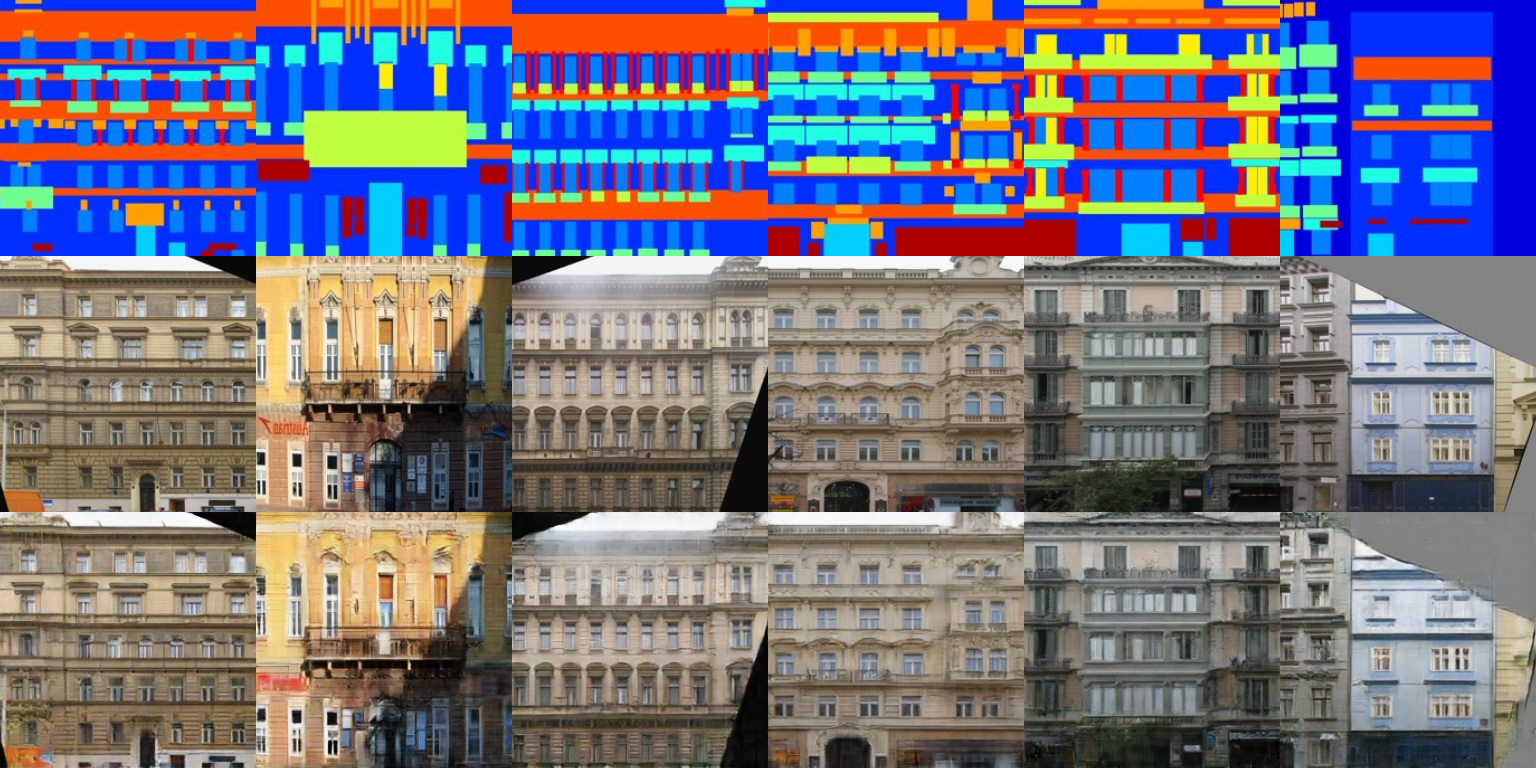

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


[147/150][58500] Loss_D: 0.449196 Loss_G: 1.879729 loss_L1: 0.084742 5774.94913411


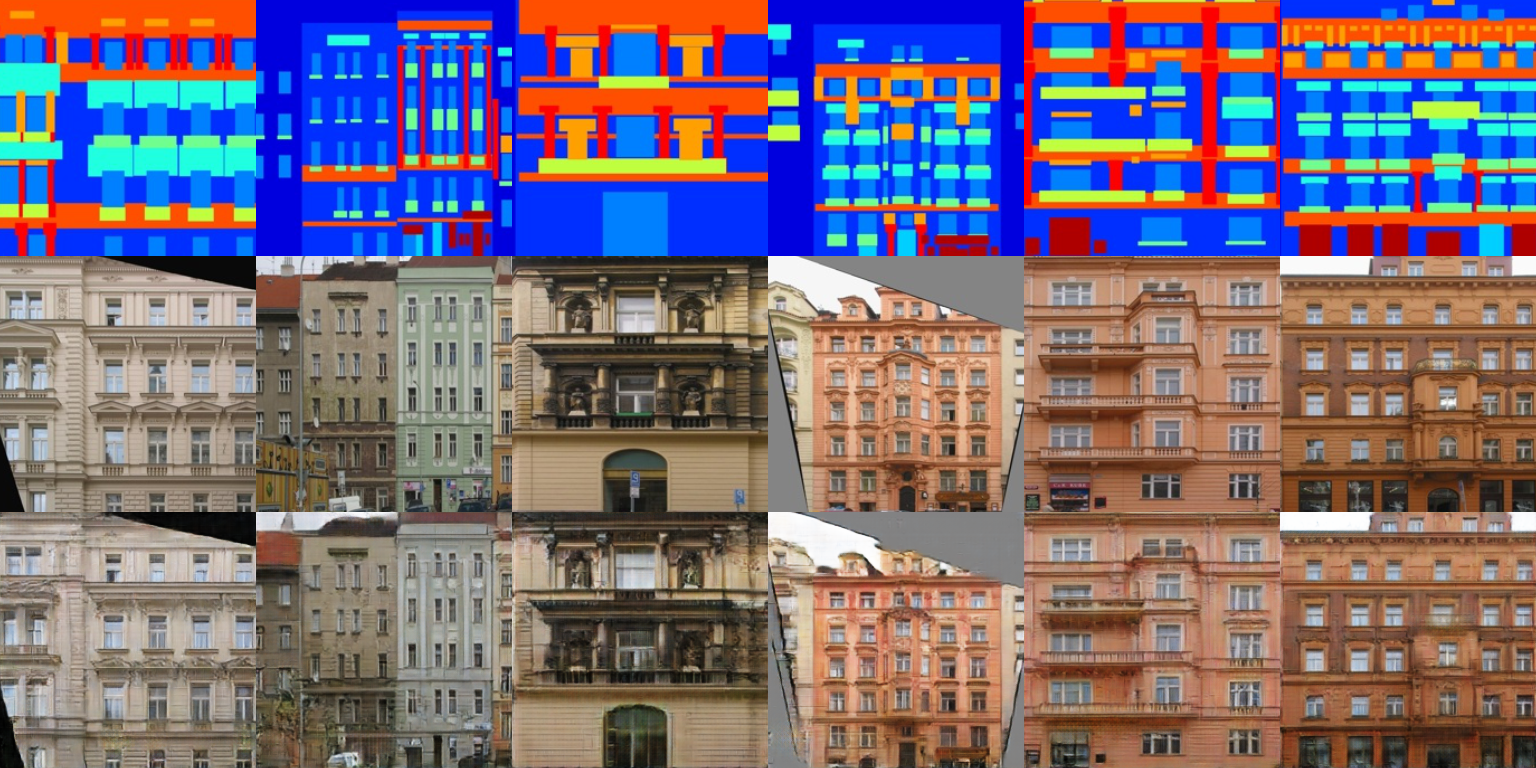

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


[149/150][59000] Loss_D: 0.453965 Loss_G: 1.912287 loss_L1: 0.085052 5824.30711317


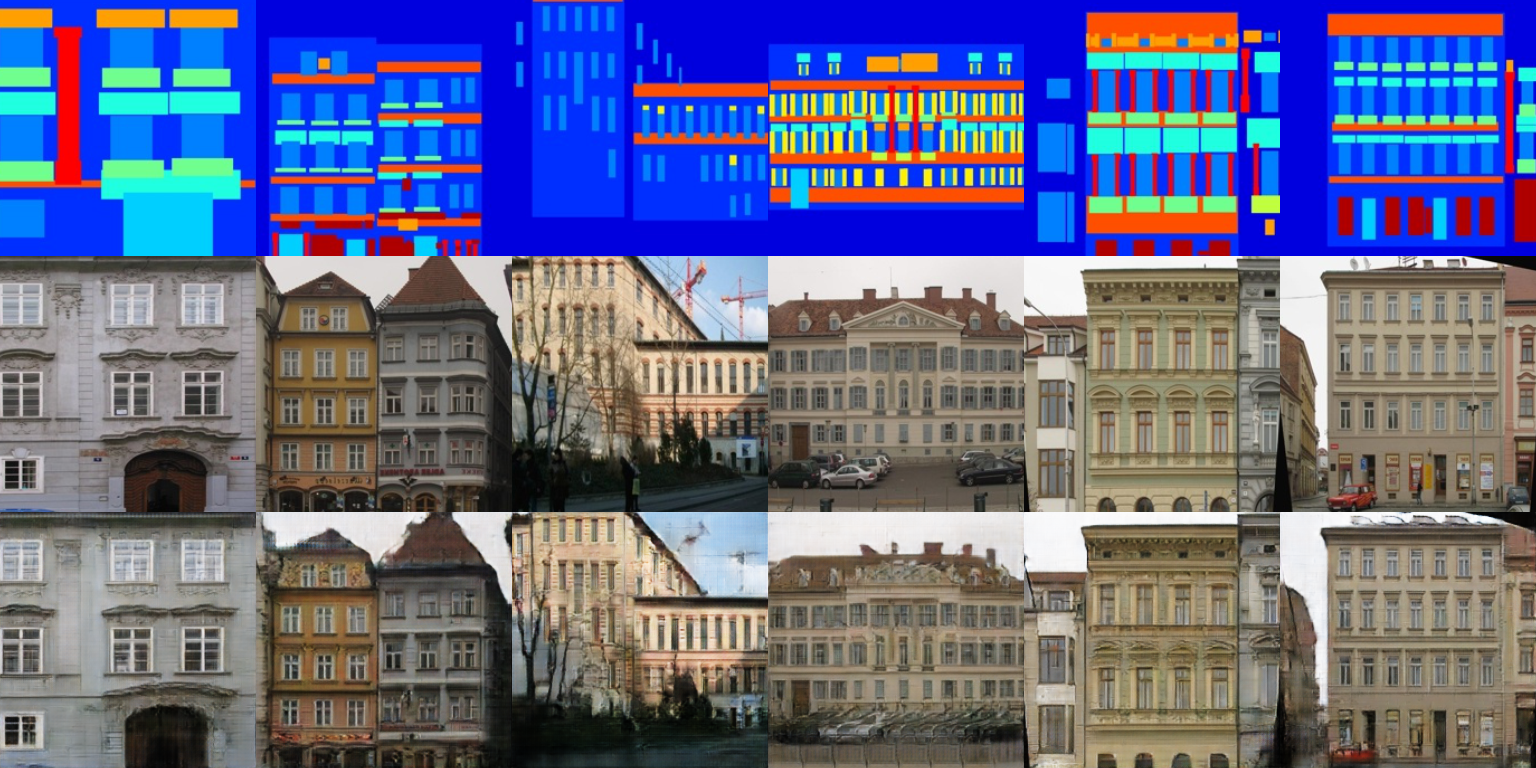

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [49]:
import time
from IPython.display import clear_output
t0 = time.time()
niter = 150
gen_iterations = 0
errL1 = epoch = errG = 0
errL1_sum = errG_sum = errD_sum = 0

display_iters = 500
val_batch = minibatch(valAB, 6, direction)
train_batch = minibatch(trainAB, batchSize, direction)

while epoch < niter: 
    epoch, trainA, trainB = next(train_batch)   
    vA, vB = V(trainA), V(trainB)
    errD,  = netD_train(vA, vB)
    errD_sum +=errD

    # epoch, trainA, trainB = next(train_batch)
    errG, errL1 = netG_train(vA, vB)
    errG_sum += errG
    errL1_sum += errL1
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        if gen_iterations%(5*display_iters)==0:
            clear_output()
        print('[%d/%d][%d] Loss_D: %f Loss_G: %f loss_L1: %f'
        % (epoch, niter, gen_iterations, errD_sum/display_iters, 
           errG_sum/display_iters, errL1_sum/display_iters), time.time()-t0)
        _, valA, valB = train_batch.send(6)
        vA, vB = V(valA),V(valB)
        fakeB = netG_gen(vA)
        showX(np.concatenate([valA, valB, fakeB], axis=0), 3)
        
        errL1_sum = errG_sum = errD_sum = 0
        _, valA, valB = next(val_batch)
        fakeB = netG_gen(V(valA))
        showX(np.concatenate([valA, valB, fakeB], axis=0), 3)     

-------------------------